In [208]:
from matplotlib.image import imread
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import tifffile as tiff

In [2]:
#resize board image to (640, 640)
def resize_board_image(img_path):
    img = Image.open(img_path)
    img = img.resize((640, 640))
    img.save(img_path)
    return img_path

In [3]:
#turn grayscale; size 1D output
def grayscale(board):
    #grayscale value
    #RGB Value to grayscale formula (NTSC):
    #0.299 ∙ Red + 0.587 ∙ Green + 0.114 ∙ Blue
    board_gray = []
    for i in range(board.shape[0]):
        board_gray_row = []
        for j in range (board.shape[1]):
            r = board[i,j,0]
            g = board[i,j,1]
            b = board[i,j,2]
            board_gray_row.append(0.299*r + 0.587*g + 0.114*b)
        board_gray.append(board_gray_row)
    return np.array(board_gray)

In [4]:
#isolate each square on board
def get_squares(board):
    squares = []
    square_width = int(board.shape[0]/8)
    square_height = int(board.shape[1]/8)
    for i in range(8):
        squares_row = []
        for j in range (8):
            square = board[(square_height*i):(square_height*(i+1)), (square_width*j):(square_width*(j+1))]
            squares_row.append(square)
        squares.append(squares_row)
    return np.array(squares)

In [5]:
#crop out border
def crop(source, value):
    square = []
    for i in range(int(source.shape[0]*value), int(source.shape[0]*(1-value))):
        square_row = []
        for j in range (int(source.shape[0]*value), int(source.shape[0]*(1-value))):
            square_row.append(source[i][j])
        square.append(square_row)
    return np.array(square)

In [6]:
#save piece as tiff files
def save_img(img, save_path, tag, num):
    if num < 10:
        img.save(f"{save_path}/{tag}00{num}.tiff")
    elif num < 100:
        img.save(f"{save_path}/{tag}0{num}.tiff")
    else:
        img.save(f"{save_path}/{tag}{num}.tiff")

In [7]:
#iterate over and save pieces
def save_board_pieces(white_below, board_path, lb, db, lw, dw):
    board = imread(resize_board_image(board_path))
    squares = get_squares(grayscale(board))
    
    if white_below:
        #black pieces
        for i in range(8):
            img = Image.fromarray(crop(squares[0,i],0.125))
            if i%2==0: #even index -> light square
                lb += 1
                save_img(img, "light_squares/black_pieces", "lb", lb)
            else:
                db += 1
                save_img(img, "dark_squares/black_pieces", "db", db)
        #get pawn for each square color
        img = Image.fromarray(crop(squares[1,0],0.125))
        db += 1
        save_img(img, "dark_squares/black_pieces", "db", db)
        img = Image.fromarray(crop(squares[1,1],0.125))
        lb += 1
        save_img(img, "light_squares/black_pieces", "lb", lb)

        #white pieces
        for i in range(8):
            img = Image.fromarray(crop(squares[7,i],0.125))
            if i%2==0: #even index -> dark square
                dw += 1
                save_img(img, "dark_squares/white_pieces", "dw", dw)
            else:
                lw += 1
                save_img(img, "light_squares/white_pieces", "lw", lw)
        #get pawn for each square color
        img = Image.fromarray(crop(squares[6,0],0.125))
        lw += 1
        save_img(img, "light_squares/white_pieces", "lw", lw)
        img = Image.fromarray(crop(squares[6,1],0.125))
        dw += 1
        save_img(img, "dark_squares/white_pieces", "dw", dw)
        
    else:
        #black pieces
        for i in range(8):
            img = Image.fromarray(crop(squares[7,i],0.125))
            if i%2==0: #even index -> dark square
                db += 1
                save_img(img, "dark_squares/black_pieces", "db", db)
            else:
                lb += 1
                save_img(img, "light_squares/black_pieces", "lb", lb)
        #get pawn for each square color
        img = Image.fromarray(crop(squares[6,0],0.125))
        lb += 1
        save_img(img, "light_squares/black_pieces", "lb", lb)
        img = Image.fromarray(crop(squares[6,1],0.125))
        db += 1
        save_img(img, "dark_squares/black_pieces", "db", db)

        #white pieces
        for i in range(8):
            img = Image.fromarray(crop(squares[0,i],0.125))
            if i%2==0: #even index -> light square
                lw += 1
                save_img(img, "light_squares/white_pieces", "lw", lw)
            else:
                dw += 1
                save_img(img, "dark_squares/white_pieces", "dw", dw)
        #get pawn for each square color
        img = Image.fromarray(crop(squares[1,0],0.125))
        dw += 1
        save_img(img, "dark_squares/white_pieces", "dw", dw)
        img = Image.fromarray(crop(squares[1,1],0.125))
        lw += 1
        save_img(img, "light_squares/white_pieces", "lw", lw)
    
    return [lb, db, lw, dw]

In [11]:
#get samples from boards
def get_board_pieces():
    #initialize number tags
    lb = 0
    db = 0
    lw = 0
    dw = 0

    #black above; white below
    path = "boards/ba_wb"
    for board_name in os.listdir(path):
        lb, db, lw, dw = save_board_pieces(True, f"{path}/{board_name}", lb, db, lw, dw)
    #white above; black below
    path = "boards/wa_bb"
    for board_name in os.listdir(path):
        lb, db, lw, dw = save_board_pieces(False, f"{path}/{board_name}", lb, db, lw, dw)

In [8]:
#get feature vector
def feature_vector(array): #ndarray input
    return np.reshape(array, array.size)

In [9]:
#"distance" from avg_img
def euclidean_distance(v1, v2): #ndarray inputs
    if(v1.size != v2.size):
        print("Error")
    squared_differences = 0
    for i in range(v1.size):
        squared_differences += pow((v1[i] - v2[i]), 2)
    return np.sqrt(squared_differences)

In [229]:
#get distance of each sample
def get_distances(avg_img_fvector, folder_path):
    distances = []
    for image in os.listdir(folder_path):
        img_fvector = feature_vector(tiff.imread(f"{folder_path}/{image}"))
        distances.append(euclidean_distance(avg_img_fvector, img_fvector))
    return np.array(distances)

In [221]:
#create "average" image for each: db, dw, lb, lw
def get_avg_img():
    #dark_squares
    folder = "dark_squares"
    #db
    avg_img_db = np.zeros((60, 60))
    n = 0
    for image in os.listdir("dark_squares/black_pieces"):
        array = tiff.imread(f"dark_squares/black_pieces/{image}")
        avg_img_db += array
        n += 1
    avg_img_db /= n
    #dw
    avg_img_dw = np.zeros((60, 60))
    n = 0
    for image in os.listdir("dark_squares/white_pieces"):
        array = tiff.imread(f"dark_squares/white_pieces/{image}")
        avg_img_dw += array
        n += 1
    avg_img_dw /= n

    #light_squares
    folder = "light_squares"
    #lb
    avg_img_lb = np.zeros((60, 60))
    n = 0
    for image in os.listdir("light_squares/black_pieces"):
        array = tiff.imread(f"light_squares/black_pieces/{image}")
        avg_img_lb += array
        n += 1
    avg_img_lb /= n
    #lw
    avg_img_lw = np.zeros((60, 60))
    n = 0
    for image in os.listdir("light_squares/white_pieces"):
        array = tiff.imread(f"light_squares/white_pieces/{image}")
        avg_img_lw += array
        n += 1
    avg_img_lw /= n
    
    return [avg_img_db, avg_img_dw, avg_img_lb, avg_img_lw]

In [218]:
#binary classifier
class SVM:

    def __init__(self, learning_rate=0.001, reg=0.01):
        self.weights = None
        self.bias = None
        self.learning_rate = learning_rate
        self.reg = reg
        
    def fit(self, X, y): #X & y as ndarrays
        n_samples, n_features = X.shape

        y_labels = np.where(y <= 0, -1, 1) #class labels

        # init weights
        self.weights = np.zeros(n_features) # can be randomized
        self.bias = 0

        for _ in range(1000): #no. of iterations can be changed
            for i, x_i in enumerate(X):
                if y_labels[i] * (np.dot(x_i, self.weights) - self.bias) >= 1:
                    self.weights -= self.learning_rate * (2 * self.reg * self.weights)
                else:
                    self.weights -= self.learning_rate * (2 * self.reg * self.weights - np.dot(x_i, y_labels[i]))
                    self.bias -= self.learning_rate * y_labels[i]


    def predict(self, X):
        approx = np.dot(X, self.weights) - self.bias
        return np.sign(approx)

In [237]:
#draw plot: training data, support vectors, decision boundary
def visualize_svm(svm, X, y):
    def get_hyperplane_value(x, weights, bias, offset):
        return (-weights[0] * x + bias + offset) / weights[1]

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_facecolor("khaki")
    plt.scatter(X[:, 0], X[:, 1], marker="o", c=y, cmap="binary")
    plt.xlabel("Distance from Black Avg")
    plt.ylabel("Distance from White Avg")

    x0_1 = np.amin(X[:, 0])
    x0_2 = np.amax(X[:, 0])

    x1_1 = get_hyperplane_value(x0_1, svm.weights, svm.bias, 0)
    x1_2 = get_hyperplane_value(x0_2, svm.weights, svm.bias, 0)

    x1_1_m = get_hyperplane_value(x0_1, svm.weights, svm.bias, -1)
    x1_2_m = get_hyperplane_value(x0_2, svm.weights, svm.bias, -1)

    x1_1_p = get_hyperplane_value(x0_1, svm.weights, svm.bias, 1)
    x1_2_p = get_hyperplane_value(x0_2, svm.weights, svm.bias, 1)

    ax.plot([x0_1, x0_2], [x1_1, x1_2], "y--") # decision boundary
    ax.plot([x0_1, x0_2], [x1_1_m, x1_2_m], "w") # white sv 
    ax.plot([x0_1, x0_2], [x1_1_p, x1_2_p], "k") # black sv
    

    x1_min = np.amin(X[:, 1])
    x1_max = np.amax(X[:, 1])
    ax.set_ylim([x1_min - 3, x1_max + 3])

    plt.show()

In [222]:
#compute accuracy
def accuracy(actual, predictions):
    accuracy = np.sum(actual == predictions) / len(actual)
    return accuracy

In [241]:
avg_img_db, avg_img_dw, avg_img_lb, avg_img_lw = get_avg_img()

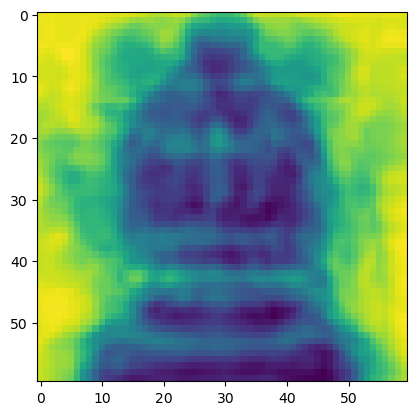

In [242]:
plt.imshow(avg_img_db)

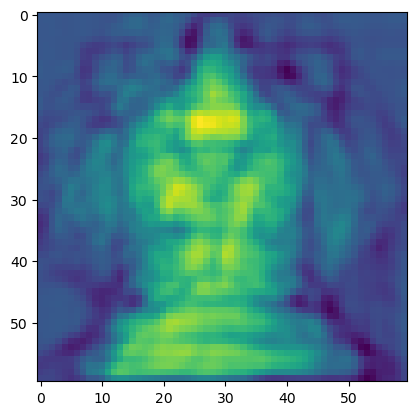

In [243]:
plt.imshow(avg_img_dw)

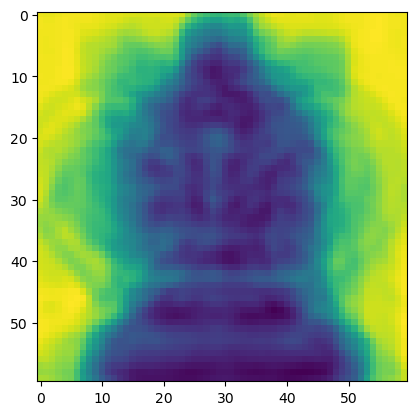

In [244]:
plt.imshow(avg_img_lb)

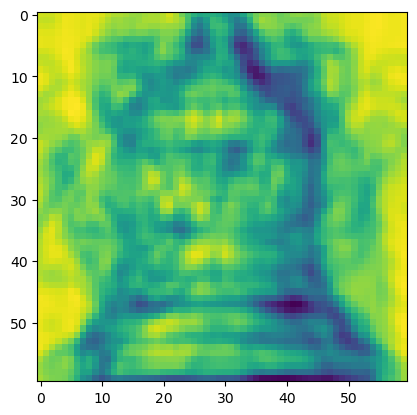

In [245]:
plt.imshow(avg_img_lw)

In [240]:
# get_board_pieces()

In [230]:
db_distances = get_distances(feature_vector(avg_img_db), "dark_squares/black_pieces")
dw_distances = get_distances(feature_vector(avg_img_dw), "dark_squares/white_pieces")
lb_distances = get_distances(feature_vector(avg_img_lb), "light_squares/black_pieces")
lw_distances = get_distances(feature_vector(avg_img_lw), "light_squares/white_pieces")

In [231]:
#x: distance to avg_img_db; y: distance to avg_img_dw
#dark 
d_b_to_b = get_distances(feature_vector(avg_img_db), "dark_squares/black_pieces")
d_b_to_w = get_distances(feature_vector(avg_img_dw), "dark_squares/black_pieces")
d_w_to_b = get_distances(feature_vector(avg_img_db), "dark_squares/white_pieces")
d_w_to_w = get_distances(feature_vector(avg_img_dw), "dark_squares/white_pieces")
db = np.array([(lambda i: np.array([d_b_to_b[i],d_b_to_w[i]]))(i) for i in range(d_b_to_b.size)])
dw = np.array([(lambda i: np.array([d_w_to_b[i],d_w_to_w[i]]))(i) for i in range(d_w_to_b.size)])
x_ds_train = np.concatenate((db,dw),axis=0)
y_ds_train = np.append(np.ones(dw.shape[0]), (np.ones(db.shape[0])*-1)) #white: 1; black: -1

# light
l_b_to_b = get_distances(feature_vector(avg_img_lb), "light_squares/black_pieces")
l_b_to_w = get_distances(feature_vector(avg_img_lw), "light_squares/black_pieces")
l_w_to_b = get_distances(feature_vector(avg_img_lb), "light_squares/white_pieces")
l_w_to_w = get_distances(feature_vector(avg_img_lw), "light_squares/white_pieces")
lb = np.array([(lambda i: np.array([l_b_to_b[i],l_b_to_w[i]]))(i) for i in range(l_b_to_b.size)])
lw = np.array([(lambda i: np.array([l_w_to_b[i],l_w_to_w[i]]))(i) for i in range(l_w_to_b.size)])
x_ls_train = np.concatenate((lb,lw),axis=0)
y_ls_train = np.append(np.ones(lw.shape[0]), (np.ones(lb.shape[0])*-1))

SVM classification accuracy 0.9857142857142858


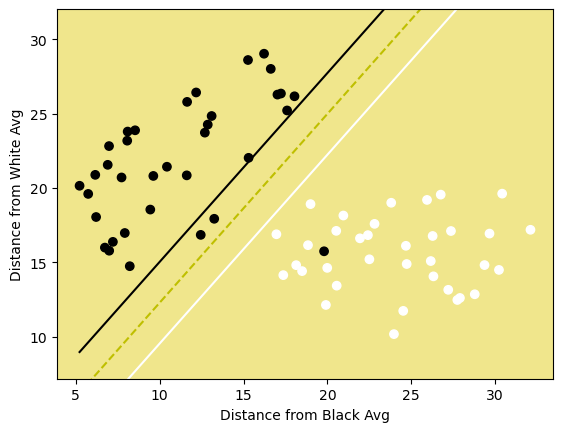

In [238]:
#TEST Training

#dark squares
d_svm = SVM()
d_svm.fit(x_ds_train, y_ds_train)
predictions = d_svm.predict(x_ds_train)
print("SVM classification accuracy", accuracy(y_ds_train, predictions))
visualize_svm(d_svm, x_ds_train, y_ds_train)

SVM classification accuracy 0.9857142857142858


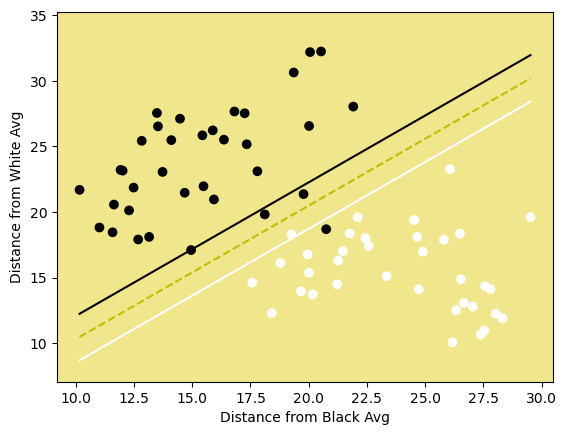

In [239]:
#light squares
l_svm = SVM()
l_svm.fit(x_ls_train, y_ls_train)
predictions = l_svm.predict(x_ls_train)
print("SVM classification accuracy", accuracy(y_ls_train, predictions))
visualize_svm(l_svm, x_ls_train, y_ls_train)